### Load the database

In [425]:
import pandas as pd
print(pd.__version__)

1.2.4


In [426]:
from sociophysicsDataHandler import SociophysicsDataHandler
import pandas as pd
import matplotlib.pyplot as pl

student_config = True

file_target = 'asdz/platform2.2/20200428/ASDZ_Perron2.2_2020042815_trajectorie.parquet' 

if student_config:
    dh = SociophysicsDataHandler()
    dh.fetch_prorail_data_from_path(file_target)
else:
    webdav_basepath='/Crowdflow (Projectfolder)/ProRail_USE_LL_data'
    dh = SociophysicsDataHandler(basepath=webdav_basepath)
    
    dh.fetch_prorail_data_from_path(file_target)
                           # ,basepath=webdav_basepath)

print('The available files are the following:')
dh.list_files("econophysics/reddit/")
for path in dh.filelist['path']:
    print(path)

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/asdz/platform2.2/20200428/ASDZ_Perron2.2_2020042815_trajectorie.parquet


data fetched. Accessible as <this-object>.df
The available files are the following:
targeting path /storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/
Files listed. Accessible as <this-object>.filelist
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_AAPL.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_AMC.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_BBBY.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_FIZZ.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_GME.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_LGND.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_NOKIA.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/comments_VIAC.tar.gz
/storage/surfsara/ProRail_USE_LL_data/econophysics/reddit/submissions_wallstreetbets_AAPL_start20200901_end20210706.json
/storage/surfsara/ProRail_USE_LL_data/e

In [427]:
targetPosts = True
stock = 'GME'

if targetPosts:
    filename = 'submissions_wallstreetbets_' + stock + '_start20200901_end20210706.json'
    if stock == 'GME':
        filename = 'submissions_wallstreetbets_GME_start20200901_end20210624.json'
else:
    filename = 'comments_' + stock + '.tar.gz'
    
dh.fetch_econophysics_data_from_path("econophysics/reddit/" + filename)
df = dh.df
# print one of the entries (in this case, the fifth):
df

for col in df.columns:
    print(col)
    
df

trying to fetch: /storage/surfsara/ProRail_USE_LL_data\econophysics/reddit/submissions_wallstreetbets_GME_start20200901_end20210624.json
data fetched. Accessible as <this-object>.df
id
all_awardings
author
author_fullname
created_utc
full_link
gildings
id.1
link_flair_css_class
link_flair_text
num_comments
num_crossposts
over_18
permalink
pinned
retrieved_on
score
selftext
subreddit
subreddit_id
subreddit_subscribers
title
total_awards_received
upvote_ratio
url
created
removed_by_category


,id,all_awardings,author,author_fullname,created_utc,full_link,gildings,id.1,link_flair_css_class,link_flair_text,...,selftext,subreddit,subreddit_id,subreddit_subscribers,title,total_awards_received,upvote_ratio,url,created,removed_by_category
0,o72ekv,[],Siphen_,t2_a0s1xfzf,1624546147,https://www.reddit.com/r/wallstreetbets/commen...,{},o72ekv,dd,DD,...,If you find where they are hiding taking profi...,wallstreetbets,t5_2th52,10584237,Citadel Capital Replenishment,0,1.0,https://www.reddit.com/r/wallstreetbets/commen...,1624538947,None
1,o72axq,[],Obvious-Amoeba-7158,t2_5kecmdlv,1624545829,https://www.reddit.com/r/wallstreetbets/commen...,{},o72axq,meme,Meme,...,None,wallstreetbets,t5_2th52,10584217,A bird took a shit on my right shoulder. That ...,0,1.0,https://i.redd.it/kz3w2tqa78771.jpg,1624538629,moderator
2,o728za,[],Obvious-Amoeba-7158,t2_5kecmdlv,1624545659,https://www.reddit.com/r/wallstreetbets/commen...,{},o728za,news,News,...,None,wallstreetbets,t5_2th52,10584198,A bird took a shit on my right shoulder. That ...,0,1.0,https://i.redd.it/8mfoeejs68771.jpg,1624538459,moderator
3,o7284r,[],QuantitativEasing,t2_51vqmztv,1624545587,https://www.reddit.com/r/wallstreetbets/commen...,{},o7284r,yolo,YOLO,...,None,wallstreetbets,t5_2th52,10584191,Been with GME since $6,0,1.0,https://www.reddit.com/gallery/o7284r,1624538387,None
4,o723cs,[],Shlome_Mendlovits,t2_auf64xr4,1624545165,https://www.reddit.com/r/wallstreetbets/commen...,{},o723cs,dd,DD,...,"$PUBM STOCK IS 55% SHORTED, it is the MOST SHO...",wallstreetbets,t5_2th52,10584165,"$PUBM STOCK IS 55% SHORTED, it is the MOST SHO...",0,1.0,https://www.reddit.com/r/wallstreetbets/commen...,1624537965,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175412,ikrq8w,[],DeepFuckingValue,t2_49l8qytq,1598990735,https://www.reddit.com/r/wallstreetbets/commen...,{},ikrq8w,yolo,YOLO,...,None,wallstreetbets,t5_2th52,1452992,GME YOLO month-start update — Sep 1 2020,0,1.0,https://i.redd.it/r47cc12lelk51.png,1598983535,None
175413,ikpgw9,[],airdoon,t2_10emmm,1598983707,https://www.reddit.com/r/wallstreetbets/commen...,{},ikpgw9,question,Discussion,...,This is for all of you who think GME is the ne...,wallstreetbets,t5_2th52,1452670,GME short squeeze,0,1.0,https://www.reddit.com/r/wallstreetbets/commen...,1598976507,None
175414,ikp9ie,[],cyanlce,t2_zaweod7,1598983100,https://www.reddit.com/r/wallstreetbets/commen...,{},ikp9ie,question,Discussion,...,[removed],wallstreetbets,t5_2th52,1452638,$GME short squeeze to the moon,0,1.0,https://www.reddit.com/r/wallstreetbets/commen...,1598975900,moderator
175415,ikeagj,[],King_Tendie_69,t2_5wcvwhh8,1598936908,https://www.reddit.com/r/wallstreetbets/commen...,{},ikeagj,question,Discussion,...,[https://www.marketwatch.com/investing/stock/g...,wallstreetbets,t5_2th52,1451373,GME: Who is wielding adamantium gauntlets?,0,1.0,https://www.reddit.com/r/wallstreetbets/commen...,1598929708,None


### Create time sorted reddit post df

In [428]:
redditPosts = df.set_index('created_utc')
redditPosts.sort_index(inplace=True)
redditPosts.index = pd.to_datetime(redditPosts.index, origin='unix', unit='s')

redditPosts
#This is now sorted on time

#Set rolling window to 5 days, by default this rolling window will take the right-most boundary as center
#Pretty aweosme
redditRollingAmount = redditPosts[['id']].rolling(window = '1H').count()
redditRollingAmount = redditRollingAmount.rename(columns={'id':'rolling_count'})

redditRollingAmount

,rolling_count
created_utc,
2020-09-01 04:12:17,1.0
2020-09-01 05:08:28,2.0
2020-09-01 17:58:20,1.0
2020-09-01 18:08:27,2.0
2020-09-01 20:05:35,1.0
...,...
2021-06-24 14:32:45,6.0
2021-06-24 14:39:47,7.0
2021-06-24 14:40:59,8.0


### Stock preparation

In [429]:
dh.fetch_econophysics_data_from_path("econophysics/prices/hourly_prices.csv")
df = dh.df
df

trying to fetch: /storage/surfsara/ProRail_USE_LL_data\econophysics/prices/hourly_prices.csv
data fetched. Accessible as <this-object>.df


,AAPL,AMC,BBBY,FIZZ,GME,LGND,NOKIA,VIAC
2020-08-31 20:00:00,128.705970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.1155,NaN
2020-09-01 05:00:00,131.482293,NaN,12.18,NaN,NaN,NaN,4.0575,NaN
2020-09-01 06:00:00,131.750970,NaN,NaN,NaN,NaN,NaN,4.0535,NaN
2020-09-01 07:00:00,131.741019,NaN,NaN,38.163127,NaN,NaN,4.0800,27.204146
...,...,...,...,...,...,...,...,...
2021-07-14 15:00:00,149.320000,34.86,28.17,44.250000,171.46,119.51,NaN,42.070000
2021-07-14 16:00:00,149.210000,33.42,27.87,43.700000,167.61,118.22,NaN,41.920000
2021-07-14 17:00:00,149.290000,33.43,27.89,43.700000,167.62,118.16,NaN,41.920000
2021-07-14 18:00:00,149.430000,NaN,27.95,43.560000,NaN,NaN,NaN,41.800000


In [430]:
dh.fetch_econophysics_data_from_path("econophysics/prices/hourly_prices.csv")
prices_hour = dh.df
prices_hour.index = pd.to_datetime(prices_hour.index) # to be sure that the index is in the pandas DateTime format

# the times you see in the index of prices_hour are expressed in New York time (American Eastern Time) 
# American Eastern Time is defined as UTC-5 in autumn and winter, and UTC-4 in spring and summer (daylight saving)
import datetime as dt
from dateutil import tz # library to treat timezones
NYC = tz.gettz('America/New_York') # define the New York timezone

new_index_list = []
for i in range(len(prices_hour)):
    # for each index, make the previous index transformation:
    old_index = prices_hour.index[i]
    dat = str(old_index.date())
    dt1 = dt.datetime(int(dat[0:4]), int(dat[5:7]),int(dat[8:10]), tzinfo=NYC)
    UTC_lag = dt1.utcoffset() / dt.timedelta(hours=1)
    new_index = prices_hour.index[i] - pd.Timedelta(hours=UTC_lag)
    # attach the UTC index to the new index list:
    new_index_list.append(new_index)
    
# set the new UTC index to the prices_hour dataframe:
prices_hour.index = new_index_list

prices_hour #corrected reddit time prices

trying to fetch: /storage/surfsara/ProRail_USE_LL_data\econophysics/prices/hourly_prices.csv
data fetched. Accessible as <this-object>.df


,AAPL,AMC,BBBY,FIZZ,GME,LGND,NOKIA,VIAC
2020-09-01 00:00:00,128.705970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.1155,NaN
2020-09-01 09:00:00,131.482293,NaN,12.18,NaN,NaN,NaN,4.0575,NaN
2020-09-01 10:00:00,131.750970,NaN,NaN,NaN,NaN,NaN,4.0535,NaN
2020-09-01 11:00:00,131.741019,NaN,NaN,38.163127,NaN,NaN,4.0800,27.204146
...,...,...,...,...,...,...,...,...
2021-07-14 19:00:00,149.320000,34.86,28.17,44.250000,171.46,119.51,NaN,42.070000
2021-07-14 20:00:00,149.210000,33.42,27.87,43.700000,167.61,118.22,NaN,41.920000
2021-07-14 21:00:00,149.290000,33.43,27.89,43.700000,167.62,118.16,NaN,41.920000
2021-07-14 22:00:00,149.430000,NaN,27.95,43.560000,NaN,NaN,NaN,41.800000


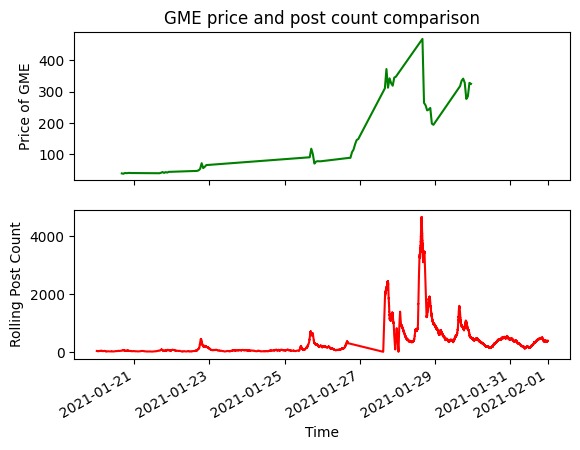

(18646.40256597222, 18659.599841435185, 15.237500000000004, 490.4925)

In [431]:
import matplotlib.pyplot as pl
stock = 'GME'
start_month = '2021-01-20'
end_month = '2021-01-31'
prices_toPlot = prices_hour[[stock]][start_month:end_month]
prices_toPlot = prices_toPlot.dropna()

redditRollingAmount_toPlot = redditRollingAmount[['rolling_count']][start_month:end_month]

fig, axes = pl.subplots(nrows=2, ncols=1, sharex=True)

prices_toPlot.plot(ax=axes[0], color='g')
axes[0].set(xlabel='b')
axes[0].set(ylabel=f'Price of {stock}')
axes[0].set(title='GME price and post count comparison')
axes[0].get_legend().remove()

redditRollingAmount_toPlot.plot(ax=axes[1], color='r')
axes[1].set(xlabel='Time')
axes[1].set(ylabel=f'Rolling Post Count')
axes[1].get_legend().remove()

pl.show()

prices_toPlot

axes[0].axis()

Text(0.5, 1.0, 'GME post category January 1st till 22nd')

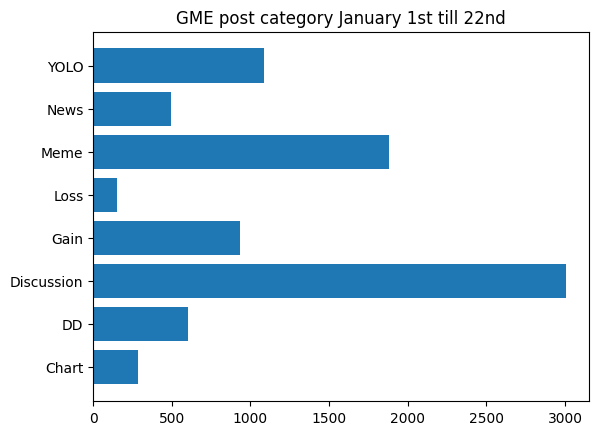

In [432]:
before_peak_start = '2021-01-01'
before_peak_end = '2021-01-22'
after_peak_start = '2021-01-23'
after_peak_end = '2021-01-30'

redditPostsBeforePeak = redditPosts[['link_flair_text']][before_peak_start:before_peak_end].dropna()
redditPostsAfterPeak = redditPosts[['link_flair_text']][after_peak_start:after_peak_end].dropna()

countFlairsBefore = {}
for val in redditPostsBeforePeak['link_flair_text']:
    countFlairsBefore[val] = 0
    
countFlairsBefore = dict(sorted(countFlairsBefore.items()))

for r in redditPostsBeforePeak['link_flair_text']:
    countFlairsBefore[r] = countFlairsBefore[r] + 1
    
countFlairsAfter = {}
for val in redditPostsAfterPeak['link_flair_text']:
    countFlairsAfter[val] = 0
    
countFlairsAfter = dict(sorted(countFlairsAfter.items()))

for r in redditPostsAfterPeak['link_flair_text']:
    countFlairsAfter[r] = countFlairsAfter[r] + 1


countFlairsBefore = {k: v for k, v in countFlairsBefore.items() if v > 150}
countFlairsAfter = {k: v for k, v in countFlairsAfter.items() if v > 800}

pl.barh(range(len(countFlairsBefore)), list(countFlairsBefore.values()), tick_label=list(countFlairsBefore.keys()))
pl.title('GME post category January 1st till 22nd')

Text(0.5, 1.0, 'GME post category January 23rd till 30th')

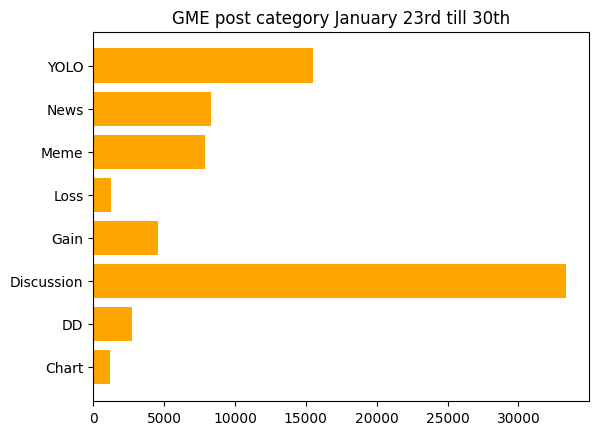

In [433]:
pl.barh(range(len(countFlairsAfter)), list(countFlairsAfter.values()), tick_label=list(countFlairsAfter.keys()), color='orange')
pl.title('GME post category January 23rd till 30th')

## VADER, textblob sentiment. VADER below.

In [434]:
#pip install vaderSentiment

In [435]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
def sentiment_classifier(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
    print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
 
    else :
        print("Neutral")
        
def sentiment_scores(sentence):
 
    sid_obj = SentimentIntensityAnalyzer()
 
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    return sentiment_dict['compound']

In [436]:
sentence = "I love the TU/e. It may have it's downsides but generally it's pretty swell."

sentiment_classifier(sentence)

Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'compound': 0.7845}
sentence was rated as  0.0 % Negative
sentence was rated as  63.5 % Neutral
sentence was rated as  36.5 % Positive
Sentence Overall Rated As Positive


In [437]:
# redditpostsRelevant = redditPosts.query('link_flair_text == "Discussion" or link_flair_text == "News" or link_flair_text == "Loss" or link_flair_text == "Gain"')

# redditpostsRelevant['text_sentiment_score'] = redditpostsRelevant['title'].apply(sentiment_scores)
# #takes extremely long, might want to include some kind of progress printing and do it on a pc.
# redditpostsRelevant

# #also for now there is only title implementation as selftext might be missing (in the case of memes for example)
# #but that might actuall©y be an advantage, filtering out memes and removed posts in order to make scoring even more accurate.

In [438]:
# redditpostsRelevant.to_csv('redditpostsRevelant.csv')
#imagine overwriting this file...

# Getting short interest data

In [439]:
short_interest = pd.read_csv('short_interestFIZZ&LGND&AAPL&GME&AMC.csv')
short_interest = short_interest.drop(columns=['Unnamed: 0', 'Unnamed: 4'])

unique_vals = short_interest['Instrument'].unique()


for unique_instr in unique_vals:
    print("\n" + unique_instr)
    print(short_interest.groupby(short_interest.Instrument).get_group(unique_instr))
    
GME_shorts = short_interest.groupby(short_interest.Instrument).get_group("GME.N")

GME_shorts["Date"] = pd.to_datetime(GME_shorts['Date'], format='%Y-%m-%dT%H:%M:%SZ')


AAPL.O
    Instrument                  Date  Short Interest Pct
0       AAPL.O  2020-01-03T00:00:00Z            1.038199
1       AAPL.O  2020-01-10T00:00:00Z            1.038199
2       AAPL.O  2020-01-17T00:00:00Z            0.948841
3       AAPL.O  2020-01-24T00:00:00Z            0.948841
4       AAPL.O  2020-01-31T00:00:00Z            0.949465
..         ...                   ...                 ...
199     AAPL.O  2023-10-27T00:00:00Z            0.595016
200     AAPL.O  2023-11-03T00:00:00Z            0.631451
201     AAPL.O  2023-11-10T00:00:00Z            0.631341
202     AAPL.O  2023-11-17T00:00:00Z            0.631341
203     AAPL.O  2023-11-24T00:00:00Z            0.631341

[204 rows x 3 columns]

FIZZ.O
    Instrument                  Date  Short Interest Pct
204     FIZZ.O  2020-01-03T00:00:00Z           17.029749
205     FIZZ.O  2020-01-10T00:00:00Z           17.029749
206     FIZZ.O  2020-01-17T00:00:00Z           16.406647
207     FIZZ.O  2020-01-24T00:00:00Z           1

C:\Users\Saber\AppData\Local\Temp\ipykernel_18580\2739123404.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GME_shorts["Date"] = pd.to_datetime(GME_shorts['Date'], format='%Y-%m-%dT%H:%M:%SZ')


In [440]:
GME_shorts = GME_shorts.rename({'Date': 'ds'}, axis='columns')
GME_shorts.set_index('ds', inplace=True)
GME_shorts

,Instrument,Short Interest Pct
ds,,
2020-01-03,GME.N,95.081698
2020-01-10,GME.N,95.081698
2020-01-17,GME.N,98.849894
2020-01-24,GME.N,98.849894
2020-01-31,GME.N,96.121610
...,...,...
2023-10-27,GME.N,19.184333
2023-11-03,GME.N,19.636403
2023-11-10,GME.N,19.636403


In [441]:
GME_shorts = GME_shorts.drop(columns=['Instrument'])
#get rid of this fing colum bro

## Time-series test

In [442]:
#!pip install prophet

In [443]:
prices_prophet = prices_hour[['GME']]
prices_prophet.reset_index(level=0, inplace=True)
prices_prophet = prices_prophet.rename({'index': 'ds', 'GME': 'y'}, axis='columns')
prices_prophet

,ds,y
0,2020-09-01 00:00:00,NaN
1,2020-09-01 08:00:00,NaN
2,2020-09-01 09:00:00,NaN
3,2020-09-01 10:00:00,NaN
4,2020-09-01 11:00:00,NaN
...,...,...
3729,2021-07-14 19:00:00,171.46
3730,2021-07-14 20:00:00,167.61
3731,2021-07-14 21:00:00,167.62
3732,2021-07-14 22:00:00,NaN


In [444]:
prices_prophet = prices_prophet.dropna()
prices_prophet

,ds,y
7,2020-09-01 14:00:00,6.810
8,2020-09-01 15:00:00,7.410
9,2020-09-01 16:00:00,7.110
10,2020-09-01 17:00:00,7.495
11,2020-09-01 18:00:00,7.490
...,...,...
3727,2021-07-14 17:00:00,175.000
3728,2021-07-14 18:00:00,173.800
3729,2021-07-14 19:00:00,171.460
3730,2021-07-14 20:00:00,167.610


In [445]:
merge_short_n_price = pd.merge_asof(prices_prophet, GME_shorts, on='ds', direction='backward')
#use backward direction to prevent bias.
merge_short_n_price

,ds,y,Short Interest Pct
0,2020-09-01 14:00:00,6.810,85.993275
1,2020-09-01 15:00:00,7.410,85.993275
2,2020-09-01 16:00:00,7.110,85.993275
3,2020-09-01 17:00:00,7.495,85.993275
4,2020-09-01 18:00:00,7.490,85.993275
...,...,...,...
1733,2021-07-14 17:00:00,175.000,11.452507
1734,2021-07-14 18:00:00,173.800,11.452507
1735,2021-07-14 19:00:00,171.460,11.452507
1736,2021-07-14 20:00:00,167.610,11.452507


In [446]:
#This typo has been here for way too long
sentiment_values = pd.read_csv('redditpostsRevelant.csv')

sentiment_values = sentiment_values[['created_utc', 'text_sentiment_score']]

sentiment_values['created_utc'] = pd.to_datetime(sentiment_values['created_utc'])

In [447]:
sentiment_values = sentiment_values.rename({'created_utc':'ds'}, axis='columns')

sentiment_values = sentiment_values.set_index('ds')
sentiment_values.sort_index(inplace=True)

sentiment_values
#aggregate troll

,text_sentiment_score
ds,
2020-09-01 05:08:28,0.0000
2020-09-01 17:58:20,0.0000
2020-09-01 18:08:27,0.0000
2020-09-02 13:39:37,0.0000
2020-09-03 03:00:13,0.0000
...,...
2021-06-24 12:53:46,0.0000
2021-06-24 13:11:48,0.8544
2021-06-24 14:27:09,0.2960


In [448]:
sentiment_values = sentiment_values[['text_sentiment_score']].rolling(window = '1D').sum()

#Normal
sentiment_values['text_sentiment_score'] = sentiment_values['text_sentiment_score'] #* abs(sentiment_values['text_sentiment_score'])

#Squared sentiment (retains negatives)
sentiment_values['text_sentiment_score'] = sentiment_values['text_sentiment_score'] * abs(sentiment_values['text_sentiment_score'])

#No negative sentiment
sentiment_values['text_sentiment_score'] = max(0, sentiment_values['text_sentiment_score'])

#Squared sentiment (removes negatives)
sentiment_values['text_sentiment_score'] = sentiment_values['text_sentiment_score'] * sentiment_values['text_sentiment_score']


#NOW MERGE!

In [449]:
merged_all = pd.merge_asof(merge_short_n_price, sentiment_values, on='ds', direction='backward')
merged_all
#In case of gme the sentiment only really goes up till 06-24 so yknow

,ds,y,Short Interest Pct,text_sentiment_score
0,2020-09-01 14:00:00,6.810,85.993275,0.0000
1,2020-09-01 15:00:00,7.410,85.993275,0.0000
2,2020-09-01 16:00:00,7.110,85.993275,0.0000
3,2020-09-01 17:00:00,7.495,85.993275,0.0000
4,2020-09-01 18:00:00,7.490,85.993275,0.0000
...,...,...,...,...
1733,2021-07-14 17:00:00,175.000,11.452507,0.3726
1734,2021-07-14 18:00:00,173.800,11.452507,0.3726
1735,2021-07-14 19:00:00,171.460,11.452507,0.3726
1736,2021-07-14 20:00:00,167.610,11.452507,0.3726


In [450]:
partial_data = merged_all.set_index('ds')
partial_data = partial_data['2020-09-01':'2021-01-10']
test_set = merged_all.set_index('ds')
test_set = test_set['2021-01-11':'2021-03-11']
test_set = test_set.reset_index()

In [451]:
partial_data = partial_data.reset_index()
partial_data

,ds,y,Short Interest Pct,text_sentiment_score
0,2020-09-01 14:00:00,6.810,85.993275,0.0000
1,2020-09-01 15:00:00,7.410,85.993275,0.0000
2,2020-09-01 16:00:00,7.110,85.993275,0.0000
3,2020-09-01 17:00:00,7.495,85.993275,0.0000
4,2020-09-01 18:00:00,7.490,85.993275,0.0000
...,...,...,...,...
709,2021-01-08 19:00:00,17.880,102.077804,1.6039
710,2021-01-08 20:00:00,17.600,102.077804,1.5657
711,2021-01-08 21:00:00,17.890,102.077804,2.0448
712,2021-01-08 22:00:00,17.690,102.077804,2.9405


In [452]:
from prophet import Prophet
prophet_model = Prophet(daily_seasonality=True)

In [453]:
prophet_model.add_regressor('Short Interest Pct')
prophet_model.add_regressor('text_sentiment_score', prior_scale=10.0)

prophet_model.fit(partial_data)

20:02:35 - cmdstanpy - INFO - Chain [1] start processing
20:02:35 - cmdstanpy - INFO - Chain [1] done processing


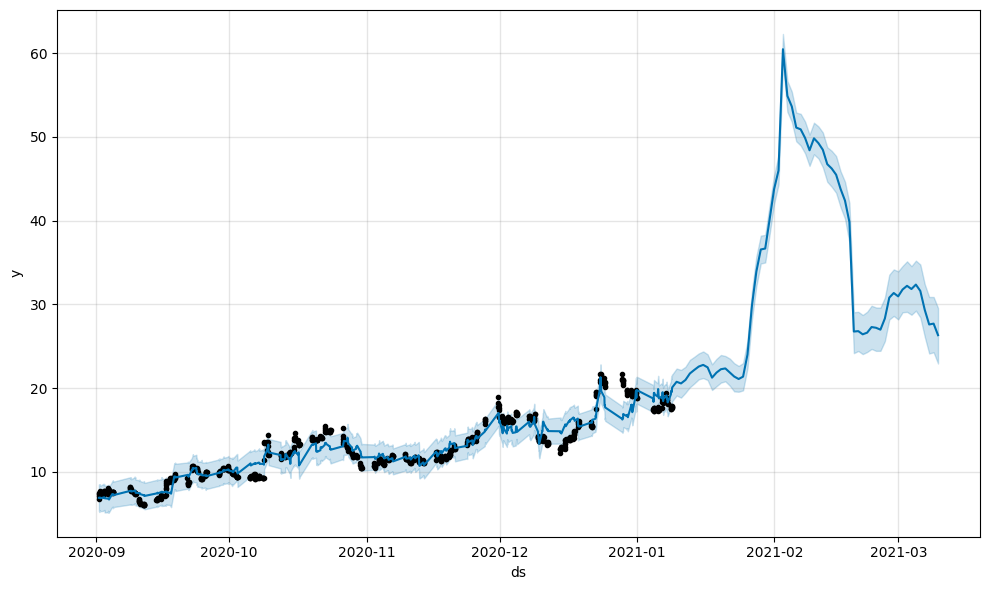

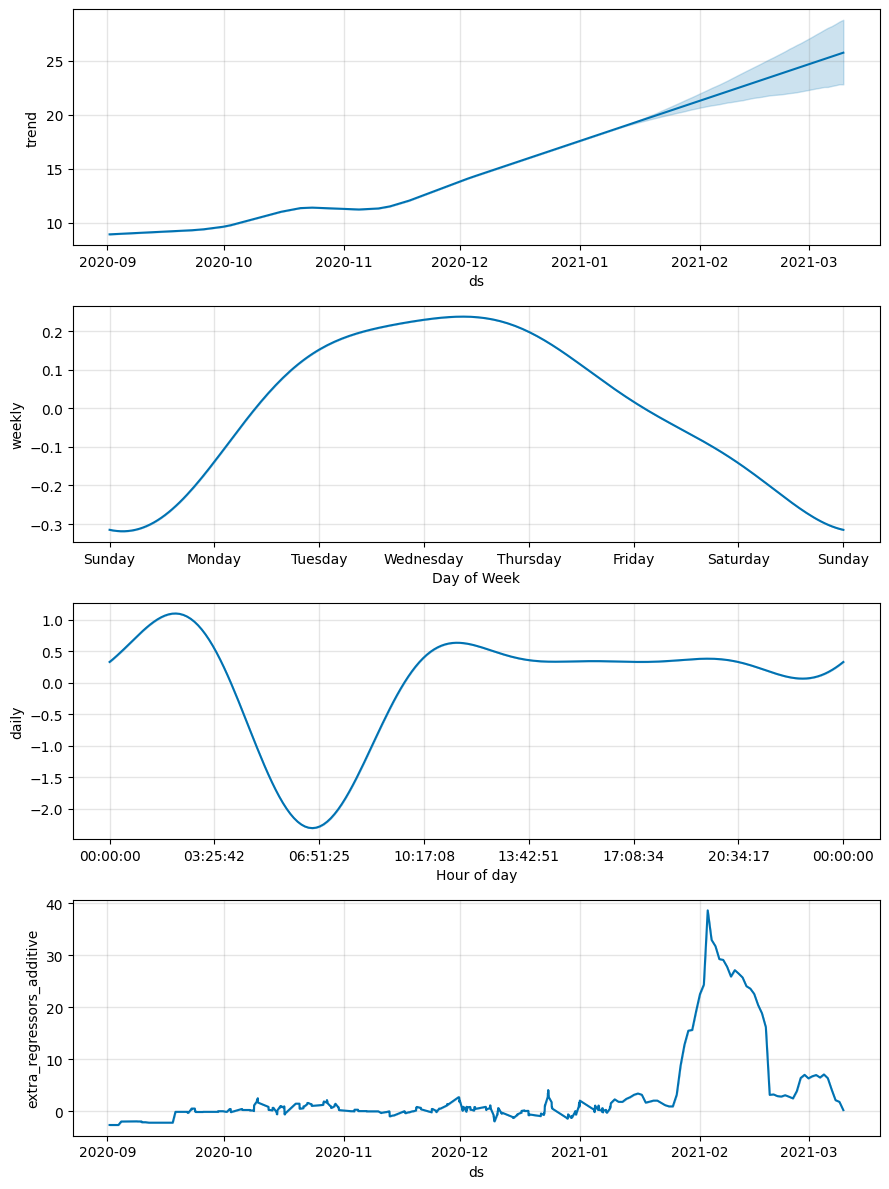

In [454]:
future = prophet_model.make_future_dataframe(periods=60)
future['Short Interest Pct'] = merged_all['Short Interest Pct']
future['text_sentiment_score'] = merged_all['text_sentiment_score']
forecast = prophet_model.predict(future)
figure1 = prophet_model.plot(forecast)
figure2 = prophet_model.plot_components(forecast)

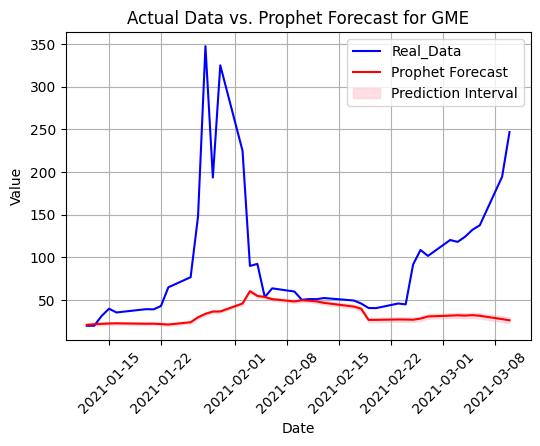

In [455]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'test_set' is your DataFrame with actual data and 'forecast' is the Prophet forecast DataFrame
# ...

# Convert the 'ds' column in 'test_set' to a datetime index
test_set['ds'] = pd.to_datetime(test_set['ds'])
test_set = test_set.set_index('ds')

# Convert the 'ds' column in 'forecast' to a datetime index
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast = forecast.set_index('ds')

# Merge the 'test_set' and 'forecast' DataFrames based on their datetime index
merged_data = pd.merge(test_set, forecast[['yhat', 'yhat_lower', 'yhat_upper']], left_index=True, right_index=True)

# Plot the actual data and Prophet forecast
plt.figure(figsize=(6, 4))
plt.plot(merged_data.index, merged_data['y'], label='Real_Data', color='blue')
plt.plot(merged_data.index, merged_data['yhat'], label='Prophet Forecast', color='red')
plt.fill_between(merged_data.index, merged_data['yhat_lower'], merged_data['yhat_upper'], color='pink', alpha=0.5, label='Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Actual Data vs. Prophet Forecast for ' + stock)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [456]:
# Assuming 'forecast' DataFrame has a 'ds' column of datetime objects
forecast.index = pd.to_datetime(forecast.index)

# Define your date range
start_date = pd.to_datetime('2020-03-11')
end_date = pd.to_datetime('2021-03-11')

# Use boolean indexing to select the rows within the specified date range
forecast_test = forecast[(forecast.index >= start_date) & (forecast.index <= end_date)]

In [457]:
test_set
# forecast_test = forecast_test.set_index('ds')

,y,Short Interest Pct,text_sentiment_score
ds,,,
2021-01-11 16:00:00,20.47,102.077804,4.7273
2021-01-11 17:00:00,19.34,102.077804,3.7826
2021-01-11 18:00:00,19.36,102.077804,3.7674
2021-01-11 19:00:00,19.61,102.077804,4.9134
2021-01-11 20:00:00,20.40,102.077804,5.5727
...,...,...,...
2021-03-11 19:00:00,256.45,20.359496,42.5453
2021-03-11 20:00:00,261.59,20.359496,43.1527
2021-03-11 21:00:00,262.00,20.359496,43.9051


In [458]:
# # Select only the rows in test_data that have matching dates in forecast
test_set_final = test_set[test_set.index.isin(forecast_test.index)]
forecast_test = forecast_test[forecast_test.index.isin(test_set_final.index)]

In [459]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(test_set_final['y'], forecast_test['yhat'])
print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 62.646644909034116
